In [1]:
import random
import datetime
import numpy as np

import scipy.sparse as sp
import pandas as pd

from itertools import islice, cycle
from more_itertools import pairwise
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender, CosineRecommender

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(17, 9)})

from IPython.core.display import display, HTML, clear_output
display(HTML('<style>.container { width:80% !important; }</style>'))
display(HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display(HTML('<style>div#notebook { font-size:12px !important; }</style>'))

/var/folders/m6/zwm77pk94gzgvxhxv086mjychvzkhw/T/ipykernel_72879/2836973646.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/var/folders/m6/zwm77pk94gzgvxhxv086mjychvzkhw/T/ipykernel_72879/2836973646.py:23: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


### Импортируем некоторые полезные функции

In [2]:
from tools import *

### Загрузим преобработанные данные

In [3]:
users_df = pd.read_csv('users_processed.csv',)
items_df = pd.read_csv('items_processed.csv',)
interactions_df = pd.read_csv('interactions_processed.csv', parse_dates=['last_watch_dt'])

In [4]:
submission = pd.read_csv('sample_submission.csv')

### Посмотрим на распределение просмотренных item у пользователей и возьмем медиану

In [5]:
df_user_gr = interactions_df.groupby('user_id').item_id.nunique().reset_index()

In [6]:
df_user_gr['item_id'].quantile(0.5)

2.0

### Посмотрим на распределение доли процента смотрения фильмов/сериалов у пользователей

<AxesSubplot:>

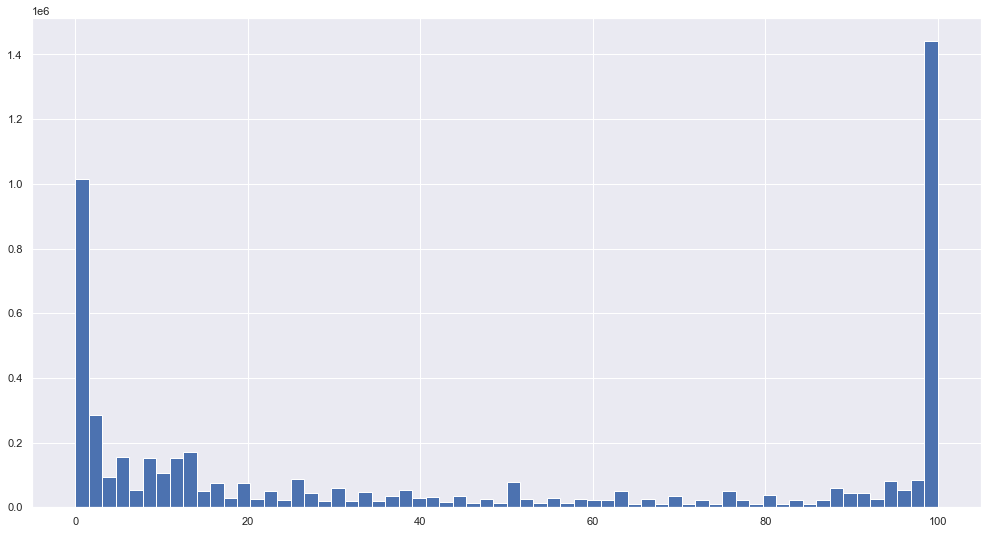

In [7]:
interactions_df['watched_pct'].hist(bins = 64)

Выберем пороги для горячих пользователей

In [8]:
interactions_df_hot = interactions_df[(interactions_df['watched_pct'] >= 5) &
                                      (interactions_df['user_id'].isin(df_user_gr[df_user_gr['item_id'] >= 3]['user_id'].unique()))].copy()

In [9]:
test_hot = submission.merge(interactions_df_hot[['user_id']].drop_duplicates(), on = 'user_id', how = 'inner')

### Сделаем матрицу весов, зависящую от даты последнего просмотра

In [10]:
dt_max = np.datetime64(interactions_df['last_watch_dt'].max())

In [11]:
interactions_df['date_weight'] = 1 / ((dt_max - interactions_df['last_watch_dt'].values).astype('timedelta64[D]') / np.timedelta64(1, 'D') + 1)

### Посмотрим на распределение весов

<AxesSubplot:>

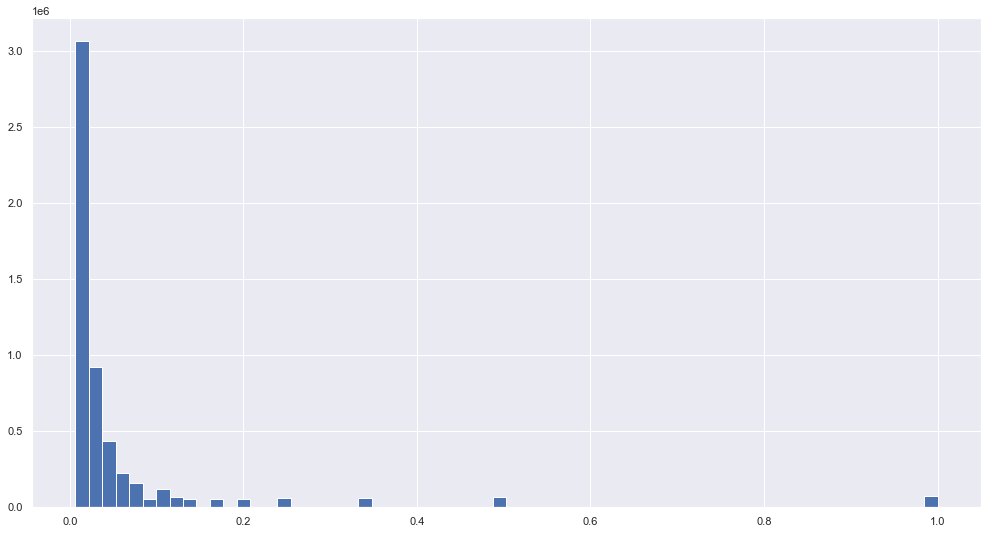

In [12]:
interactions_df['date_weight'].hist(bins = 64)

In [13]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,date_weight
0,176549,9506,2021-05-11,4250,72,0.009615
1,699317,1659,2021-05-29,8317,100,0.011628
2,656683,7107,2021-05-09,10,0,0.009434
3,864613,7638,2021-07-05,14483,100,0.020408
4,964868,9506,2021-04-30,6725,100,0.008696


### Сделаем кросс-валидацию по времени

In [14]:
last_date = interactions_df_hot['last_watch_dt'].max().normalize()
folds = 3
start_date = last_date - pd.Timedelta(days=folds*7)
start_date, last_date

(Timestamp('2021-08-01 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [15]:
cv = TimeRangeSplit(start_date=start_date, periods=folds+1, freq='W')

cv.max_n_splits, cv.get_n_splits(interactions_df_hot, datetime_column='last_watch_dt')

(3, 3)

In [16]:
cv.date_range

DatetimeIndex(['2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22'], dtype='datetime64[ns]', freq='W-SUN')

In [17]:
folds_with_stats = list(cv.split(
    interactions_df_hot, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='last_watch_dt',
    fold_stats=True
))

folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])

Already seen number: 0
Already seen number: 0
Already seen number: 0


In [18]:
folds_info_with_stats

,Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
0,2021-08-01,2021-08-08,2838079,22589,59544,215,6008,0,192585
1,2021-08-08,2021-08-15,3096216,20026,54179,142,4243,0,202560
2,2021-08-15,2021-08-22,3357198,16466,51633,115,3554,0,210855


Сделаем маппинг айдишников

In [19]:
users_inv_mapping = dict(enumerate(interactions_df_hot['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

items_inv_mapping = dict(enumerate(interactions_df_hot['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

In [20]:
validation_results = pd.DataFrame()
top_N_fit = 400
top_N = 10
last_n_days = 60
for train_idx, test_idx, info in folds_with_stats:
    train = interactions_df_hot.loc[train_idx]

    date_window = train['last_watch_dt'].max() - pd.DateOffset(days=last_n_days)
    train = train[train['last_watch_dt'] >= date_window]

    test = interactions_df_hot.loc[test_idx]

    train_mat = get_coo_matrix(
        train,
        users_mapping=users_mapping,
        items_mapping=items_mapping,
    ).tocsr()

    model = TFIDFRecommender(K=top_N_fit)
    model.fit(train_mat.T, show_progress=False) 

    mapper = generate_implicit_recs_mapper( 
        model,
        train_mat,
        top_N,
        users_mapping,
        items_inv_mapping,
        filter_already_liked_items=True
    )
    recs = generate_recs(model, mapper, test['user_id'].unique())

    fold_result = compute_metrics(train, test, recs, top_N)
    validation_results = validation_results.append(fold_result, ignore_index=True)

In [21]:
validation_results.agg({'MAP@10':'mean'})

MAP@10    0.091944
dtype: float64

### Обучим tfidf на всей матрице 

In [22]:
users_inv_mapping = dict(enumerate(interactions_df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

items_inv_mapping = dict(enumerate(interactions_df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

In [23]:
train_mat = get_coo_matrix(
    interactions_df,
    users_mapping=users_mapping,
    items_mapping=items_mapping,
    weight_col='date_weight'
).tocsr()

model = TFIDFRecommender(K=top_N_fit, num_threads = 32)
model.fit(train_mat.T, show_progress=False, ) 

### Сгенерируем кандидатов, фильтруя просмотренные айтемы

In [24]:
 mapper = generate_implicit_recs_mapper( 
        model,
        train_mat,
        top_N,
        users_mapping,
        items_inv_mapping,
        filter_already_liked_items=True
    )

recs_hot = generate_recs(model, mapper, test_hot['user_id'].unique())
recs_hot = recs_hot.groupby('user_id').agg({'item_id': list}).reset_index()

In [25]:
recs_hot.head()

,user_id,item_id
0,3,"[13865, 15297, 2954, 7829, 7310, 7571, 4495, 9..."
1,11,"[4151, 10440, 13865, 9728, 142, 3734, 4880, 99..."
2,30,"[13865, 15486, 10440, 3734, 6444, 15297, 142, ..."
3,46,"[15297, 13865, 9728, 4151, 9996, 3734, 12192, ..."
4,47,"[9728, 512, 7102, 7829, 10440, 7793, 12995, 37..."


### Сделаем кросс-валидацию по времени 

In [26]:
validation_results = pd.DataFrame()
last_n_days = 21 
cols_soc_dem = ['age', 'sex']
top_N = 10

for train_idx, test_idx, info in folds_with_stats:
    train = interactions_df.loc[train_idx]
    test = interactions_df.loc[test_idx]
    
    date_window = train['last_watch_dt'].max() - pd.DateOffset(days=last_n_days)
    train_slice = pd.merge(train[train['last_watch_dt'] >= date_window], users_df, on='user_id', how='left')
    train_slice = fillna_cols(train_slice)
    
    soc_dem_recommendations = train_slice.groupby(cols_soc_dem + ['item_id']).size().to_frame().reset_index().rename(columns = {0 : 'count_pop'})
    top_soc_dem = soc_dem_recommendations.groupby(cols_soc_dem).apply(lambda x: x.sort_values('count_pop', ascending=False).item_id.values[:top_N]).reset_index().rename(columns = {0 : 'item_id'})
    
    recs = pd.DataFrame({'user_id': test['user_id'].unique()})
    recs = pd.merge(recs[['user_id']], users_df, on='user_id', how='left')
    recs = fillna_cols(recs)
    
    recs = pd.merge(recs, top_soc_dem, on = cols_soc_dem, how = 'left')
    recs = recs.drop(columns =cols_soc_dem)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    
    fold_result = compute_metrics(train, test, recs, top_N)
    validation_results = validation_results.append(fold_result, ignore_index=True)

In [27]:
validation_results.agg({'MAP@10':'mean'})

MAP@10    0.073409
dtype: float64

In [28]:
submission = pd.read_csv('sample_submission.csv')

### Вычислим "холодных" по нашему определению пользователей

In [29]:
test_cold = submission.merge(test_hot, on = 'user_id', how = 'left')
test_cold = test_cold[test_cold['item_id_y'].isnull()]
test_cold = test_cold.rename(columns = {'item_id_x' : 'item_id'})[['user_id', 'item_id']]

In [30]:
test_cold.head()

,user_id,item_id
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
5,39,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
10,66,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
11,70,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


### Возьмем за последние 21 день популярные по соц дему айтемы

In [31]:
last_n_days = 21 
train = interactions_df
date_window = train['last_watch_dt'].max() - pd.DateOffset(days=last_n_days)
train_slice = pd.merge(train[train['last_watch_dt'] >= date_window], users_df, on='user_id', how='left')

In [32]:
train_slice = fillna_cols(train_slice)

In [33]:
train_slice.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,date_weight,age,income,sex,kids_flg
0,1016458,354,2021-08-14,1672,25,0.111111,age_18_24,income_20_40,M,True
1,884009,693,2021-08-04,703,14,0.052632,age_18_24,income_40_60,F,False
2,203219,13582,2021-08-22,6975,100,1.000000,age_unknown,income_unknown,sex_unknown,False
3,602509,496,2021-08-06,10421,1,0.058824,age_unknown,income_unknown,sex_unknown,False
4,215229,7793,2021-08-01,873,14,0.045455,age_35_44,income_20_40,F,True


### Посчитаем топ популярных айтемов за этот период для всех комбинаций age и sex

In [34]:
cols_soc_dem = ['age', 'sex']

In [35]:
soc_dem_recommendations = train_slice.groupby(cols_soc_dem + ['item_id']).size().to_frame().reset_index().rename(columns = {0 : 'count_pop'})
top_soc_dem = soc_dem_recommendations.groupby(cols_soc_dem).apply(lambda x: x.sort_values('count_pop', ascending=False).item_id.values[:top_N]).reset_index().rename(columns = {0 : 'item_id'})
top_soc_dem.head()

,age,sex,item_id
0,age_18_24,F,"[9728, 15297, 10440, 4151, 3734, 7793, 12192, ..."
1,age_18_24,M,"[9728, 10440, 7793, 15297, 13865, 3734, 4151, ..."
2,age_18_24,sex_unknown,"[9728, 10440, 15297, 4151, 13865, 12192, 3734,..."
3,age_25_34,F,"[15297, 10440, 9728, 4151, 3734, 12192, 13865,..."
4,age_25_34,M,"[9728, 10440, 15297, 7793, 13865, 3734, 12192,..."


In [36]:
recs_cold = pd.DataFrame({'user_id': test_cold['user_id'].unique()})
recs_cold = pd.merge(recs_cold[['user_id']], users_df, on='user_id', how='left')
recs_cold = fillna_cols(recs_cold)

In [37]:
recs_cold.head()

,user_id,age,income,sex,kids_flg
0,29,age_unknown,income_unknown,sex_unknown,False
1,33,age_unknown,income_unknown,sex_unknown,False
2,39,age_unknown,income_unknown,sex_unknown,False
3,66,age_35_44,income_40_60,M,False
4,70,age_18_24,income_unknown,F,False


In [38]:
top_soc_dem.head()

,age,sex,item_id
0,age_18_24,F,"[9728, 15297, 10440, 4151, 3734, 7793, 12192, ..."
1,age_18_24,M,"[9728, 10440, 7793, 15297, 13865, 3734, 4151, ..."
2,age_18_24,sex_unknown,"[9728, 10440, 15297, 4151, 13865, 12192, 3734,..."
3,age_25_34,F,"[15297, 10440, 9728, 4151, 3734, 12192, 13865,..."
4,age_25_34,M,"[9728, 10440, 15297, 7793, 13865, 3734, 12192,..."


In [39]:
recs_cold = pd.merge(recs_cold, top_soc_dem, on = cols_soc_dem, how = 'left')
recs_cold = recs_cold.drop(columns = ['income', 'kids_flg', 'age', 'sex'])

In [40]:
recs_cold.head()

,user_id,item_id
0,29,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
1,33,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
2,39,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
3,66,"[9728, 10440, 15297, 13865, 7793, 12192, 11863..."
4,70,"[9728, 15297, 10440, 4151, 3734, 7793, 12192, ..."


In [41]:
recs_cold = recs_cold.explode('item_id')
recs_cold['rank'] = recs_cold.groupby('user_id').cumcount() + 1
recs_cold = recs_cold.groupby('user_id').agg({'item_id': list}).reset_index()

In [42]:
recs_cold.head()

,user_id,item_id
0,29,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
1,33,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
2,39,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
3,66,"[9728, 10440, 15297, 13865, 7793, 12192, 11863..."
4,70,"[9728, 15297, 10440, 4151, 3734, 7793, 12192, ..."


In [43]:
recs_cold.shape

(95937, 2)

### Обьединим рекомендации 

In [44]:
recs_union = pd.concat([recs_hot, recs_cold], axis = 0)

In [45]:
recs_union = recs_union.sort_values('user_id')
recs_union = recs_union.reset_index(drop = True)

In [46]:
recs_union.head()

,user_id,item_id
0,3,"[13865, 15297, 2954, 7829, 7310, 7571, 4495, 9..."
1,11,"[4151, 10440, 13865, 9728, 142, 3734, 4880, 99..."
2,29,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."
3,30,"[13865, 15486, 10440, 3734, 6444, 15297, 142, ..."
4,33,"[10440, 15297, 9728, 4151, 12192, 13865, 2657,..."


### Сделаем проверки 

In [47]:
recs_union[recs_union['user_id'].isnull()].shape

(0, 2)

In [48]:
recs_union[recs_union['item_id'].isnull()].shape

(0, 2)

In [49]:
recs_union['len'] = recs_union['item_id'].apply(lambda x: len(x))

In [50]:
recs_union[recs_union['len'] > 10].shape

(0, 3)

### Посчитаем метрику на private и public

In [ ]:
target = pd.read_csv('final_test.csv')
final = target.groupby(['user_id', 'type']).agg({'item_id': list}).reset_index() 
final['item_id'] = final['item_id'].astype(str)

In [ ]:
recs_union['item_id'] = recs_union['item_id'].astype(str)

In [ ]:
compute_metric_leaderboard(final[final['type'] == 'private'] , recs_union)

In [ ]:
compute_metric_leaderboard(final[final['type'] == 'public'] , recs_union)

In [ ]:
recs_union.drop(['len'], axis = 1).to_csv('recs_submission.csv', index=False)